In [1]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import plot
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import xgboost
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from feature_selector import FeatureSelector
pd.set_option('display.max_columns', 100)
sns.set_theme(rc={'figure.figsize':(16,9)})
pd.set_option('display.max_rows', 179)
import optuna
from optuna import create_study, logging
from optuna.pruners import MedianPruner
from optuna.integration import XGBoostPruningCallback
setattr(pd, "Int64Index", pd.Index)
setattr(pd, "Float64Index", pd.Index)

C:\ProgramData\Anaconda3\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: dm is an invalid version and will not be supported in a future release
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: quests is an invalid version and will not be supported in a future release
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: rd is an invalid version and will not be supported in a future release
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: N-A is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
data = pd.read_csv('Desktop/Данные для разработки (1).csv', on_bad_lines='skip', sep = ';')

C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\3424554218.py:1: DtypeWarning: Columns (84,169) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Desktop/Данные для разработки (1).csv', on_bad_lines='skip', sep = ';')


# Обработка данных (даты)

In [3]:
data.drop(['PersonId', 'flagFC', 'flagSP', 'flagEF'], inplace = True, axis = 1)

In [4]:
data[['date', 'time']] = data['CreateTime'].str.split(' ', expand=True)

In [5]:
data.drop('time', inplace = True, axis = 1)

In [6]:
#data[['st1', 'st2', 'st3']] = data['date'].str.split('.', expand=True)

In [7]:
#data[['st1', 'st2', 'st3']]

In [8]:
data['date'] = data['date'].astype('str')

In [9]:
data['tochka'] = 0
data['shtrih'] = 0

for i in range(len(data)):
    if ('-' in data.loc[i, 'date']):
        data.loc[i, 'shtrih'] = 1
    if ('.' in data.loc[i, 'date']):
        data.loc[i, 'tochka'] = 1    

In [10]:
d1 = data[data['tochka'] == 1]
d2 = data[data['shtrih'] == 1]


In [11]:
d2[['st1','st2', 'st3']] = d2['date'].str.split('-', expand=True)
d1[['st1','st2', 'st3']] = d1['date'].str.split('.', expand=True)


C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\3082400640.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2[['st1','st2', 'st3']] = d2['date'].str.split('-', expand=True)
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\3082400640.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2[['st1','st2', 'st3']] = d2['date'].str.split('-', expand=True)
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\3082400640.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [12]:
d_promez = d1['st3']
d1['st3'] = d1['st1']
d1['st1'] = d_promez

C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\2830590014.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1['st3'] = d1['st1']
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\2830590014.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1['st1'] = d_promez


In [13]:
d1.drop(['tochka', 'shtrih'], axis = 1, inplace = True)
d1.head()

C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\4197834136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1.drop(['tochka', 'shtrih'], axis = 1, inplace = True)


,DraftId,CreateTime,Amount,age,Duration,Gender,prev_drafts_cnt,prev_loans_cnt,all_act_3_1_d,all_act_cred,all_act_cred_1,all_act_cred_2,all_act_cred_3,all_act_cred_3_1,all_act_cred_s,all_cred_rep_1,all_cred_rep_11,all_cred_rep_13,all_cred_rep_3,all_rep_cred_1,avg_12_month,avg_over_1_90,Count_0,Count_0_len_num,Count_01_len_num,Count_1,Count_12_len_num,Count_2,Count_3,Count_4,Count_456_len_num,Count_5,Count_5B_len_num,Count_6,Count_7,Count_8,Count_9,Count_B,Count_C,Count_C_len_num,Count_I,Count_R,Count_S,Count_Sp,Count_Sp_len_num,Count_T,Count_U,Count_W,cred_activ_1,cred_activ_2,...,ti_week_all,ti_year,Cred_Deb_2,Dola_RD_1,N_90_365,a_sum_Credit_700,cred_hist_1,d_cnt_12030,d_cnt_R,last_payment,miAmount_45,miAmount_90,perc_amount,s_Amount,s_Amount_30,s_Amount_60,s_Credit_befo_RD,s_cnt_cred_90,F_NumR_30_90,F_iTA_30_365,F_mfoCFor_30_180,F_IssAmnt,F_long_Card,SA,mfoCountFor30Days,outgoingTransferAmountFor365Days,outgoingTransferAmountFor90Days,N_record_IP,cred_365_count,gibdd_180_count,gibdd_180_sum,gibdd_730_count,imush_180_count,max_Summa,max_hist_IPDate,max_hist_IPEndDate,max_hist_RIDDate,min_hist_IPDate,min_hist_IPEndDate,min_hist_RIDDate,st46_3_365_count,st46_4_365_count,st47_7_730_count,sum_RIDDate_365,sum_RIDDate_730,is_paid,date,st1,st2,st3
0,44704116-DC05-48A5-863D-E2FA13495E85,13.08.2023 10:38,8900,46,31,2,5.0,1.0,"-0,020474",19,19,"0,21839",19,"0,197916",-365444,239505,"0,305181","0,283621",239505,"-0,02156","59044,74","369,7479167",210.0,"0,1852","0,2328",54.0,"0,0838",41.0,54.0,18.0,"0,0741",32.0,"0,1279",34.0,24.0,22.0,33.0,0.0,66.0,"0,0582",0.0,0.0,0.0,515.0,"0,4541",0.0,0.0,0.0,19,19,...,2.0,122.0,"1,0067",1,1,8960,73.0,1.0,0,61.0,NaN,"0,8989","0,12",8000.0,0.0,0.0,8960,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,13.08.2023,2023,08,13
1,BD18C2D6-04D5-44FD-AA0F-A61FFC06407C,20.07.2023 9:32,3000,28,29,1,4.0,3.0,0,4,4,"0,333333",4,"0,333333",-8672,15127,"0,388609","0,388609",15127,0,"1478,67",0,25.0,"0,1667","0,2",5.0,"0,0933",9.0,6.0,2.0,"0,0733",4.0,"0,16",5.0,6.0,4.0,5.0,0.0,8.0,"0,0533",0.0,0.0,0.0,67.0,"0,4467",0.0,0.0,0.0,4,4,...,2.0,11.0,"5,4473",1,1,"5447,333333",56.0,1.0,1,0.0,1,1,"0,175683",13900.0,7000.0,13900.0,16342,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20.07.2023,2023,07,20
2,C300B4A1-8083-411C-B6F5-6D88E543ACD7,03.02.2023 6:27,10000,21,31,2,6.0,1.0,"0,005575",21,17,"0,155963",21,"0,161538","-1674693,67","412698,1","0,183074","0,186292","497250,1","0,003218","199646,26","156,0283688",229.0,"0,1868","0,2178",38.0,"0,0514",25.0,38.0,19.0,"0,0546",29.0,"0,0669",19.0,16.0,4.0,14.0,0.0,90.0,"0,0734",0.0,0.0,0.0,685.0,"0,5587",0.0,0.0,0.0,17,20,...,3.0,143.0,"1,33",0,1,13300,48.0,1.0,1,15.0,NaN,1,"0,33",10000.0,0.0,10000.0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03.02.2023,2023,02,03
3,EE2E2559-43DD-4919-ADCC-2B85F803E22C,23.11.2023 20:49,15900,35,31,2,3.0,3.0,"0,001152",50,45,"0,321428",50,"0,32258","638376,99",780887,"0,387726","0,566882",2705379,"0,179156","189695,24",0,458.0,"0,2271","0,2796",106.0,"0,1155",127.0,113.0,36.0,"0,063",47.0,"0,121",44.0,40.0,27.0,86.0,0.0,93.0,"0,0461",0.0,5.0,0.0,780.0,"0,3867",0.0,0.0,0.0,45,46,...,7.0,190.0,"9,4592",0,0,50134,207.0,0.0,0,0.0,NaN,NaN,"3,436637",33900.0,0.0,0.0,90602,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,23.11.2023,2023,11,23
4,C8286AD9-9721-48F7-97C9-0AD41653272B,15.05.2023 8:01,9900,47,30,2,6.0,1.0,"0,03027",23,18,"0,260869",23,"0,291139",33875,251718,"0,277907","0,511911",727918,"0,234004","81237,37",0,156.0,"0,1518","0,1712",20.0,"0,0652",47.0,74.0,40.0,"0,1245",48.0,"0,1459",40.0,20.0,22.0,20.0,0.0,50.0,"0,0486",0.0,0.0,8.0,452.0,"0,4397",0.0,0.0,11.0,18,20,...,1.0,120.0,0,NaN,0,0,268.0,0.0,0,109.0,NaN,NaN,-1,6900.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [14]:
d2.drop(['tochka', 'shtrih'], axis = 1, inplace = True)

C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\951743598.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2.drop(['tochka', 'shtrih'], axis = 1, inplace = True)


In [15]:
data = pd.concat([d1, d2])

In [16]:
data.drop('CreateTime', axis = 1, inplace = True)

In [17]:
data.st1 = data.st1.astype('str')
data.st2 = data.st2.astype('str')
data.st3 = data.st3.astype('str')

In [18]:
data['Tdate'] = data.st1 + '-' + data.st2 + '-' + data.st3

In [19]:
data['Tdate'] = pd.to_datetime(data['Tdate'], format = "%Y-%m-%d")

In [20]:
data.head()

,DraftId,Amount,age,Duration,Gender,prev_drafts_cnt,prev_loans_cnt,all_act_3_1_d,all_act_cred,all_act_cred_1,all_act_cred_2,all_act_cred_3,all_act_cred_3_1,all_act_cred_s,all_cred_rep_1,all_cred_rep_11,all_cred_rep_13,all_cred_rep_3,all_rep_cred_1,avg_12_month,avg_over_1_90,Count_0,Count_0_len_num,Count_01_len_num,Count_1,Count_12_len_num,Count_2,Count_3,Count_4,Count_456_len_num,Count_5,Count_5B_len_num,Count_6,Count_7,Count_8,Count_9,Count_B,Count_C,Count_C_len_num,Count_I,Count_R,Count_S,Count_Sp,Count_Sp_len_num,Count_T,Count_U,Count_W,cred_activ_1,cred_activ_2,cred_activ_3,...,ti_year,Cred_Deb_2,Dola_RD_1,N_90_365,a_sum_Credit_700,cred_hist_1,d_cnt_12030,d_cnt_R,last_payment,miAmount_45,miAmount_90,perc_amount,s_Amount,s_Amount_30,s_Amount_60,s_Credit_befo_RD,s_cnt_cred_90,F_NumR_30_90,F_iTA_30_365,F_mfoCFor_30_180,F_IssAmnt,F_long_Card,SA,mfoCountFor30Days,outgoingTransferAmountFor365Days,outgoingTransferAmountFor90Days,N_record_IP,cred_365_count,gibdd_180_count,gibdd_180_sum,gibdd_730_count,imush_180_count,max_Summa,max_hist_IPDate,max_hist_IPEndDate,max_hist_RIDDate,min_hist_IPDate,min_hist_IPEndDate,min_hist_RIDDate,st46_3_365_count,st46_4_365_count,st47_7_730_count,sum_RIDDate_365,sum_RIDDate_730,is_paid,date,st1,st2,st3,Tdate
0,44704116-DC05-48A5-863D-E2FA13495E85,8900,46,31,2,5.0,1.0,"-0,020474",19,19,"0,21839",19,"0,197916",-365444,239505,"0,305181","0,283621",239505,"-0,02156","59044,74","369,7479167",210.0,"0,1852","0,2328",54.0,"0,0838",41.0,54.0,18.0,"0,0741",32.0,"0,1279",34.0,24.0,22.0,33.0,0.0,66.0,"0,0582",0.0,0.0,0.0,515.0,"0,4541",0.0,0.0,0.0,19,19,19,...,122.0,"1,0067",1,1,8960,73.0,1.0,0,61.0,NaN,"0,8989","0,12",8000.0,0.0,0.0,8960,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,13.08.2023,2023,08,13,2023-08-13
1,BD18C2D6-04D5-44FD-AA0F-A61FFC06407C,3000,28,29,1,4.0,3.0,0,4,4,"0,333333",4,"0,333333",-8672,15127,"0,388609","0,388609",15127,0,"1478,67",0,25.0,"0,1667","0,2",5.0,"0,0933",9.0,6.0,2.0,"0,0733",4.0,"0,16",5.0,6.0,4.0,5.0,0.0,8.0,"0,0533",0.0,0.0,0.0,67.0,"0,4467",0.0,0.0,0.0,4,4,4,...,11.0,"5,4473",1,1,"5447,333333",56.0,1.0,1,0.0,1,1,"0,175683",13900.0,7000.0,13900.0,16342,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20.07.2023,2023,07,20,2023-07-20
2,C300B4A1-8083-411C-B6F5-6D88E543ACD7,10000,21,31,2,6.0,1.0,"0,005575",21,17,"0,155963",21,"0,161538","-1674693,67","412698,1","0,183074","0,186292","497250,1","0,003218","199646,26","156,0283688",229.0,"0,1868","0,2178",38.0,"0,0514",25.0,38.0,19.0,"0,0546",29.0,"0,0669",19.0,16.0,4.0,14.0,0.0,90.0,"0,0734",0.0,0.0,0.0,685.0,"0,5587",0.0,0.0,0.0,17,20,21,...,143.0,"1,33",0,1,13300,48.0,1.0,1,15.0,NaN,1,"0,33",10000.0,0.0,10000.0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03.02.2023,2023,02,03,2023-02-03
3,EE2E2559-43DD-4919-ADCC-2B85F803E22C,15900,35,31,2,3.0,3.0,"0,001152",50,45,"0,321428",50,"0,32258","638376,99",780887,"0,387726","0,566882",2705379,"0,179156","189695,24",0,458.0,"0,2271","0,2796",106.0,"0,1155",127.0,113.0,36.0,"0,063",47.0,"0,121",44.0,40.0,27.0,86.0,0.0,93.0,"0,0461",0.0,5.0,0.0,780.0,"0,3867",0.0,0.0,0.0,45,46,50,...,190.0,"9,4592",0,0,50134,207.0,0.0,0,0.0,NaN,NaN,"3,436637",33900.0,0.0,0.0,90602,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,23.11.2023,2023,11,23,2023-11-23
4,C8286AD9-9721-48F7-97C9-0AD41653272B,9900,47,30,2,6.0,1.0,"0,03027",23,18,"0,260869",23,"0,291139",33875,251718,"0,277907","0,511911",727918,"0,234004","81237,37",0,156.0,"0,1518","0,1712",20.0,"0,0652",47.0,74.0,40.0,"0,1245",48.0,"0,1459",40.0,20.0,22.0,20.0,0.0,50.0,"0,0486",0.0,0.0,8.0,452.0,"0,4397",0.0,0.0,11.0,18,20,23,...,120.0,0,NaN,0,0,268.0,0.0,0,109.0,NaN,NaN,-1,6900.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [21]:
data.drop(['date', 'st1', 'st2', 'st3'], axis = 1, inplace = True)

In [22]:
fs = FeatureSelector(data = data, labels = data.columns)
fs.identify_missing(missing_threshold=0.85)
missing_features = fs.ops['missing']
columns_to_drop = missing_features

data.drop(columns_to_drop, inplace = True, axis = 1)
data = data[(data['Gender'] == 1) | (data['Gender'] == 2)]
data.fillna(0, inplace = True)

data = data.applymap(lambda x: x.replace(',', '.') if isinstance(x, str) else x)

draft = data['DraftId']
data.drop(['DraftId'], axis = 1, inplace = True)
data = data.astype('float', errors = 'ignore')


27 features with greater than 0.85 missing values.



C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\2425687760.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(0, inplace = True)
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\2425687760.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x.replace(',', '.') if isinstance(x, str) else x)


In [23]:
def remove_highly_correlated_features(df, threshold=0.8):
    """
    Удаляет столбцы из DataFrame, которые имеют корреляцию выше заданного порога.

    :param df: Входной DataFrame
    :param threshold: Порог корреляции для удаления столбцов
    :return: DataFrame без сильно коррелирующих столбцов
    """
    # Вычисление корреляционной матрицы
    corr_matrix = df.corr().abs()
    
    # Создание списка для удаления столбцов
    to_drop = set()
    
    # Перебор всех пар столбцов
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] > threshold:  # Если корреляция выше порога
                colname = corr_matrix.columns[i]  # Получаем имя столбца
                to_drop.add(colname)  # Добавляем в список для удаления

    # Удаление столбцов из DataFrame
    df.drop(columns=to_drop, inplace=True, axis = 1)
    
    return df

data = remove_highly_correlated_features(data, threshold=0.8)

 # удалили Duration, так как в дальнейшем увидели, что его IV 1.7)) сильно палит целевую переменную)



In [24]:
data['DraftId'] = draft

In [25]:
data.drop(['Count_U','Duration','dog_bad_180','Count_B'], axis = 1, inplace = True)

In [26]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

        
        # Calculate the number of events in each group (bin)
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        
        # Calculate % of events in each group.
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

        # Calculate the non events in each group.
        d['Non-Events'] = d['N'] - d['Events']
        # Calculate % of non events in each group.
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

        # Calculate WOE by taking natural log of division of % of non-events and % of events
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [27]:
a,b = iv_woe(data, 'is_paid', bins=10, show_woe=True)

C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to

Information value of Amount is 0.085885
  Variable              Cutoff      N   Events  % of Events  Non-Events  \
0   Amount  (1999.999, 7900.0]  17322  10387.0     0.130847      6935.0   
1   Amount    (7900.0, 9000.0]  20955   9147.0     0.115226     11808.0   
2   Amount    (9000.0, 9900.0]  23178   8553.0     0.107743     14625.0   
3   Amount   (9900.0, 10000.0]   4774   2307.0     0.029062      2467.0   
4   Amount  (10000.0, 11000.0]  17565   8086.0     0.101861      9479.0   
5   Amount  (11000.0, 11900.0]  15056   6634.0     0.083570      8422.0   
6   Amount  (11900.0, 12900.0]  17738   8502.0     0.107101      9236.0   
7   Amount  (12900.0, 13900.0]  14837   7487.0     0.094315      7350.0   
8   Amount  (13900.0, 15000.0]  23038  12970.0     0.163385     10068.0   
9   Amount  (15000.0, 53500.0]   9096   5310.0     0.066891      3786.0   

   % of Non-Events       WoE        IV  
0         0.082387  0.462600  0.022417  
1         0.140278 -0.196726  0.004928  
2         0

C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to

Information value of all_cred_rep_1 is 0.012303
         Variable                    Cutoff      N  Events  % of Events  \
0  all_cred_rep_1         (-0.001, 30900.0]  16369  8774.0     0.110527   
1  all_cred_rep_1        (30900.0, 62989.6]  16343  8303.0     0.104594   
2  all_cred_rep_1        (62989.6, 97920.6]  16356  7854.0     0.098938   
3  all_cred_rep_1      (97920.6, 138030.21]  16356  7576.0     0.095436   
4  all_cred_rep_1     (138030.21, 187386.0]  16356  7626.0     0.096066   
5  all_cred_rep_1      (187386.0, 249456.6]  16355  7658.0     0.096469   
6  all_cred_rep_1     (249456.6, 333101.84]  16356  7424.0     0.093521   
7  all_cred_rep_1     (333101.84, 458131.8]  16356  7575.0     0.095423   
8  all_cred_rep_1     (458131.8, 698851.85]  16357  7937.0     0.099984   
9  all_cred_rep_1  (698851.85, 33901341.88]  16355  8656.0     0.109041   

   Non-Events  % of Non-Events       WoE            IV  
0      7595.0         0.090228  0.202928  4.119408e-03  
1      8040.

C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to

Information value of Count_456_len_num is 0.0794
            Variable            Cutoff      N   Events  % of Events  \
0  Count_456_len_num  (-0.001, 0.0331]  16377  10196.0     0.128441   
1  Count_456_len_num   (0.0331, 0.047]  16375   9402.0     0.118438   
2  Count_456_len_num   (0.047, 0.0575]  16489   8668.0     0.109192   
3  Count_456_len_num  (0.0575, 0.0671]  16349   8154.0     0.102717   
4  Count_456_len_num  (0.0671, 0.0766]  16280   7790.0     0.098132   
5  Count_456_len_num  (0.0766, 0.0868]  16351   7746.0     0.097578   
6  Count_456_len_num   (0.0868, 0.098]  16382   7340.0     0.092463   
7  Count_456_len_num    (0.098, 0.112]  16297   7043.0     0.088722   
8  Count_456_len_num    (0.112, 0.131]  16341   6911.0     0.087059   
9  Count_456_len_num      (0.131, 0.4]  16318   6133.0     0.077258   

   Non-Events  % of Non-Events       WoE        IV  
0      6181.0         0.073429  0.559141  0.030759  
1      6973.0         0.082838  0.357502  0.012727  
2      782

C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to

Information value of cred_sum_1 is 0.013954
     Variable                      Cutoff      N  Events  % of Events  \
0  cred_sum_1           (-0.001, 91124.0]  16356  7629.0     0.096104   
1  cred_sum_1       (91124.0, 183563.368]  16356  7745.0     0.097565   
2  cred_sum_1      (183563.368, 284337.4]  16356  7609.0     0.095852   
3  cred_sum_1        (284337.4, 399075.0]  16356  7651.0     0.096381   
4  cred_sum_1        (399075.0, 534009.0]  16356  7845.0     0.098825   
5  cred_sum_1       (534009.0, 696491.19]  16355  7655.0     0.096431   
6  cred_sum_1       (696491.19, 907615.8]  16356  7688.0     0.096847   
7  cred_sum_1      (907615.8, 1215820.96]  16356  7938.0     0.099996   
8  cred_sum_1   (1215820.96, 1782639.456]  16356  8410.0     0.105942   
9  cred_sum_1  (1782639.456, 152162815.0]  16356  9213.0     0.116058   

   Non-Events  % of Non-Events       WoE            IV  
0      8727.0         0.103676 -0.075839  5.742499e-04  
1      8611.0         0.102298 -0.0473

C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to

Information value of delay5_33 is 0.004062
    Variable         Cutoff       N   Events  % of Events  Non-Events  \
0  delay5_33  (-0.001, 1.0]  132812  65442.0     0.824383     67370.0   
1  delay5_33     (1.0, 4.0]   15567   7202.0     0.090725      8365.0   
2  delay5_33    (4.0, 73.0]   15180   6739.0     0.084892      8441.0   

   % of Non-Events       WoE        IV  
0         0.800347  0.029590  0.000711  
1         0.099375 -0.091072  0.000788  
2         0.100278 -0.166564  0.002563  
Information value of delay60_1 is 0.022509
    Variable         Cutoff       N   Events  % of Events  Non-Events  \
0  delay60_1  (-0.001, 1.0]  132166  66523.0     0.838001     65643.0   
1  delay60_1     (1.0, 4.0]   18184   7636.0     0.096192     10548.0   
2  delay60_1    (4.0, 45.0]   13209   5224.0     0.065808      7985.0   

   % of Non-Events       WoE        IV  
0         0.779830  0.071942  0.004185  
1         0.125309 -0.264437  0.007700  
2         0.094861 -0.365676  0.010624  


C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to

Information value of partner_type_1 is 0.012405
         Variable                       Cutoff      N  Events  % of Events  \
0  partner_type_1         (-0.001, 14000000.0]  17305  8067.0     0.101621   
1  partner_type_1     (14000000.0, 28000000.0]  16109  7585.0     0.095549   
2  partner_type_1     (28000000.0, 45000040.0]  15654  7119.0     0.089679   
3  partner_type_1     (45000040.0, 72000000.0]  16642  7477.0     0.094189   
4  partner_type_1    (72000000.0, 118000000.0]  16452  7761.0     0.097767   
5  partner_type_1   (118000000.0, 156000000.0]  16044  7759.0     0.097741   
6  partner_type_1   (156000000.0, 227000100.0]  16286  8107.0     0.102125   
7  partner_type_1   (227000100.0, 322000000.0]  16365  8209.0     0.103410   
8  partner_type_1   (322000000.0, 504000000.0]  16357  8395.0     0.105753   
9  partner_type_1  (504000000.0, 8137000000.0]  16345  8904.0     0.112165   

   Non-Events  % of Non-Events       WoE        IV  
0      9238.0         0.109746 -0.076918

C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to

Information value of sum_over_1_89 is 0.02851
        Variable                   Cutoff       N   Events  % of Events  \
0  sum_over_1_89       (-0.001, 6889.468]  130847  66181.0     0.833692   
1  sum_over_1_89    (6889.468, 23766.516]   16356   6934.0     0.087349   
2  sum_over_1_89  (23766.516, 3022664.06]   16356   6268.0     0.078959   

   Non-Events  % of Non-Events       WoE        IV  
0     64666.0         0.768224  0.081783  0.005354  
1      9422.0         0.111932 -0.247985  0.006096  
2     10088.0         0.119844 -0.417264  0.017060  
Information value of sum_over_360 is 0.013511
       Variable                  Cutoff       N   Events  % of Events  \
0  sum_over_360       (-0.001, 4936.37]  147213  72864.0     0.917879   
1  sum_over_360  (4936.37, 11626886.73]   16346   6519.0     0.082121   

   Non-Events  % of Non-Events       WoE        IV  
0     74349.0         0.883257  0.038450  0.001331  
1      9827.0         0.116743 -0.351787  0.012180  
Information valu

C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to

Information value of ti_year is 0.005444
  Variable           Cutoff      N  Events  % of Events  Non-Events  \
0  ti_year   (-0.001, 12.0]  17526  8766.0     0.110427      8760.0   
1  ti_year     (12.0, 23.0]  15992  7954.0     0.100198      8038.0   
2  ti_year     (23.0, 35.0]  16638  8357.0     0.105274      8281.0   
3  ti_year     (35.0, 48.0]  16485  8259.0     0.104040      8226.0   
4  ti_year     (48.0, 62.0]  16127  8060.0     0.101533      8067.0   
5  ti_year     (62.0, 78.0]  16179  7976.0     0.100475      8203.0   
6  ti_year     (78.0, 97.0]  15875  7534.0     0.094907      8341.0   
7  ti_year    (97.0, 122.0]  16304  7761.0     0.097767      8543.0   
8  ti_year   (122.0, 161.0]  16371  7492.0     0.094378      8879.0   
9  ti_year  (161.0, 1680.0]  16062  7224.0     0.091002      8838.0   

   % of Non-Events       WoE        IV  
0         0.104068  0.059310  0.000377  
1         0.095490  0.048120  0.000227  
2         0.098377  0.067761  0.000467  
3         0.0

C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1189706358.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to

Information value of miAmount_45 is 0.076691
      Variable           Cutoff      N   Events  % of Events  Non-Events  \
0  miAmount_45  (-0.001, 0.495]  81797  34950.0     0.440271     46847.0   
1  miAmount_45   (0.495, 0.615]  16515   7921.0     0.099782      8594.0   
2  miAmount_45   (0.615, 0.727]  16531   8194.0     0.103221      8337.0   
3  miAmount_45   (0.727, 0.856]  16419   8993.0     0.113286      7426.0   
4  miAmount_45     (0.856, 1.0]  19666  11379.0     0.143343      8287.0   
5  miAmount_45     (1.0, 7.692]  12631   7946.0     0.100097      4685.0   

   % of Non-Events       WoE        IV  
0         0.556536 -0.234343  0.027246  
1         0.102096 -0.022921  0.000053  
2         0.099042  0.041324  0.000173  
3         0.088220  0.250085  0.006269  
4         0.098448  0.375707  0.016867  
5         0.055657  0.586928  0.026083  
Information value of miAmount_90 is 0.071091
      Variable           Cutoff      N   Events  % of Events  Non-Events  \
0  miAmount_90

In [28]:
a.sort_values(by = 'IV', ascending = False)

,Variable,IV
0,DraftId,0.695395
0,Count_12_len_num,0.125446
0,s_Amount_60,0.102119
0,over_mfo,0.099868
0,all_act_cred_2,0.095035
0,sum_overdue,0.089159
0,Amount,0.085885
0,Count_456_len_num,0.079400
0,miAmount_45,0.076691
0,day_overdue,0.074879


In [29]:
mas = a.sort_values(by = 'IV', ascending = False)[a.sort_values(by = 'IV', ascending = False)['IV'] > 0.002342]['Variable'].tolist()
mas.append('is_paid')# оставляем в нужных столбцах is_paid
#mas.append('Tdate')
data = data[mas]

In [30]:
data.head()

,DraftId,Count_12_len_num,s_Amount_60,over_mfo,all_act_cred_2,sum_overdue,Amount,Count_456_len_num,miAmount_45,day_overdue,s_Amount_30,miAmount_90,d_cnt_R,Dola_RD_1,s_Amount,all_act_cred,cred_date_last_1,a_sum_Credit_700,N_90_365,max_overdue,delay30_1,all_cred_rep_13,delay5_2,sum_over_89_90,avg_over_1_90,prolong_1,prolong,sum_mfo,sum_over_1_89,prev_loans_cnt,Cred_Deb_2,last_payment,delay60_1,all_act_cred_s,cred_hist_1,Tdate,d_cnt_12030,cred_date_last_2,all_cred_rep_3,cred_dura_1,delay_more_2,delay90_3,all_act_3_1_d,cred_sum_1,sum_over_360,cred_dura_3,avg_12_month,cred_date_last,partner_type_1,all_cred_rep_1,sum_over_1080,delay5_22,all_rep_cred_1,prev_drafts_cnt,partner_type_3,dog_bad,sum_debt_last,ti_year,delay5_33,ti_quarter,cred_sum_22,Gender,Count_0_len_num,is_paid
0,44704116-DC05-48A5-863D-E2FA13495E85,0.0838,0.0,35495.80,0.218390,35495.80,8900.0,0.0741,0.0,65.0,0.0,0.8989,0.0,1.0,8000.0,19.0,28.0,8960.000000,1.0,20500.00,3.0,0.283621,14.0,35495.8,369.747917,12.0,13.0,184044.46,35495.8,1.0,1.0067,61.0,0.0,-365444.00,73.0,2023-08-13,1.0,16.0,239505.0,76.0,0.0,0.0,-0.020474,784795.00,10348.1,75.0,59044.74,16.0,87000000.0,239505.0,10348.1,0.0,-0.021560,5.0,9.600000e+07,0.0,153544.46,122.0,0.0,31.0,59659.00,2.0,0.1852,1.0
1,BD18C2D6-04D5-44FD-AA0F-A61FFC06407C,0.0933,13900.0,17000.00,0.333333,17000.00,3000.0,0.0733,1.0,1940.0,7000.0,1.0000,1.0,1.0,13900.0,4.0,23.0,5447.333333,1.0,16000.00,0.0,0.388609,0.0,-6500.0,0.000000,0.0,1.0,32127.00,0.0,3.0,5.4473,0.0,0.0,-8672.00,56.0,2023-07-20,1.0,5.0,15127.0,31.0,0.0,0.0,0.000000,38926.00,0.0,31.0,1478.67,5.0,12000000.0,15127.0,0.0,0.0,0.000000,4.0,1.310000e+08,3.0,15127.00,11.0,0.0,12.0,0.00,1.0,0.1667,1.0
2,C300B4A1-8083-411C-B6F5-6D88E543ACD7,0.0514,10000.0,55878.84,0.155963,55878.84,10000.0,0.0546,0.0,1095.0,0.0,1.0000,1.0,0.0,10000.0,21.0,15.0,13300.000000,1.0,37548.52,5.0,0.186292,15.0,8500.0,156.028369,5.0,9.0,401137.44,22000.0,1.0,1.3300,15.0,1.0,-1674693.67,48.0,2023-02-03,1.0,8.0,497250.1,26844.0,0.0,0.0,0.005575,2283661.00,0.0,44946.0,199646.26,8.0,604000000.0,412698.1,0.0,2.0,0.003218,6.0,8.340000e+08,1.0,339988.79,143.0,0.0,57.0,388925.77,2.0,0.1868,1.0
3,EE2E2559-43DD-4919-ADCC-2B85F803E22C,0.1155,0.0,0.00,0.321428,0.00,15900.0,0.0630,0.0,0.0,0.0,0.0000,0.0,0.0,33900.0,50.0,32.0,50134.000000,0.0,30000.00,8.0,0.566882,27.0,0.0,0.000000,124.0,133.0,619572.52,0.0,3.0,9.4592,0.0,1.0,638376.99,207.0,2023-11-23,0.0,5.0,2705379.0,20879.0,0.0,1.0,0.001152,2014014.38,0.0,75303.0,189695.24,5.0,239000000.0,780887.0,0.0,2.0,0.179156,3.0,2.543000e+09,0.0,601167.74,190.0,3.0,28.0,1152183.00,2.0,0.2271,0.0
4,C8286AD9-9721-48F7-97C9-0AD41653272B,0.0652,0.0,80751.30,0.260869,485515.34,9900.0,0.1245,0.0,2267.0,0.0,0.0000,0.0,0.0,6900.0,23.0,70.0,0.000000,0.0,253991.16,5.0,0.511911,5.0,0.0,0.000000,16.0,18.0,117651.30,0.0,1.0,0.0000,109.0,3.0,33875.00,268.0,2023-05-15,0.0,70.0,727918.0,63.0,18.0,3.0,0.030270,908533.00,0.0,37376.0,81237.37,91.0,67000200.0,251718.0,0.0,0.0,0.234004,6.0,7.720002e+08,4.0,20000.00,120.0,4.0,30.0,111200.00,2.0,0.1518,0.0


# WOE

In [31]:
data_train = data[data['Tdate'] < pd.to_datetime('2024-02-01')]
data_test = data[data['Tdate'] > pd.to_datetime('2024-02-01')]

bad_features = ['a_sum_Credit_700',
 'sum_over_89_90',
 'all_cred_rep_3',
 'cred_dura_1',
 'cred_dura_3',
 'all_cred_rep_1',
 'sum_debt_last',
 'delay5_33',
 'cred_sum_22',
 'Count_0_len_num'] # нестабильные фичи
#bad_shap_features = ['max_overdue','all_act_3_1_d', 'cred_hist_1',
#                     'delay5_22', 'sum_mfo', 'prev_loans_cnt', 'N_90_365', 'Gender', 'sum_over_1_89', 'dog_bad',
#                    'delay_more_2', 'sum_over_1080', 'avg_over_1_90', 'prev_drafts_cnt', 'Cred_Deb_2', 'sum_over_360']

bad_features = bad_features #+ bad_shap_features

data_train.drop(bad_features, axis = 1, inplace = True)
data_test.drop(bad_features, axis = 1, inplace = True)


target = data_train['is_paid']
features = data_train.drop('is_paid', axis = 1)


C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1948442792.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.drop(bad_features, axis = 1, inplace = True)
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1948442792.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.drop(bad_features, axis = 1, inplace = True)


In [32]:
from feature_engine.encoding import WoEEncoder


cat = []
for i in data_train.columns:
    if (len(data_train[i].unique()) < 100):
        cat.append(i)
del cat[-1]
cat        
  # последний столбец - is_paid, поэтому его уберем


['Amount',
 'd_cnt_R',
 'all_act_cred',
 'N_90_365',
 'delay30_1',
 'prev_loans_cnt',
 'delay60_1',
 'd_cnt_12030',
 'delay_more_2',
 'delay90_3',
 'delay5_22',
 'prev_drafts_cnt',
 'dog_bad',
 'Gender']

In [33]:
from feature_engine.encoding import WoEEncoder


cat = []
for i in data_train.columns:
    if (len(data_train[i].unique()) < 100):
        cat.append(i)
cat        
del cat[-1]  # последний столбец - is_paid, поэтому его уберем


woe_encoder = WoEEncoder(
    variables=cat,
    ignore_format=True,
    fill_value = 0.5)

woe_encoder.fit(features[cat], target)
features[cat] = woe_encoder.transform(features[cat])
data_test[cat] = woe_encoder.transform(data_test[cat])


C:\ProgramData\Anaconda3\lib\site-packages\feature_engine\encoding\base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) Amount, all_act_cred, N_90_365, delay30_1, delay60_1, d_cnt_12030, delay_more_2, delay90_3, delay5_22, prev_drafts_cnt, dog_bad.
  warnings.warn(
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\796184037.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test[cat] = woe_encoder.transform(data_test[cat])


In [34]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, random_state = 1234, test_size = 0.2)

In [35]:
#import pickle
#with open('Desktop/Model_woe_trained_train_12.11.pkl', 'wb') as file:
#    pickle.dump(woe_encoder, file)  # Сохранение данных в файл

In [36]:
#scaler = StandardScaler()
#data[data.drop('is_paid', axis = 1).columns] = scaler.fit_transform(data.drop('is_paid', axis = 1) )

In [37]:
#with open('Desktop/Model_scaler_febr.pkl', 'wb') as file:
 #   pickle.dump(scaler, file)  # Сохранение данных в файл

# Optuna

In [38]:
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    classifier_name = trial.suggest_categorical('classifier', ['XGBClassifier'])
    
    if (classifier_name=='XGBClassifier'):
        
        max_depth = trial.suggest_int('max_depth', 2, 7, 1)
        learning_rate = trial.suggest_float('learning_rate', 0.005, 1.3)
        min_child_weight = trial.suggest_int('min_child_weight', 5, 25, 1)
        gamma = trial.suggest_float('gamma', 1, 1.5)
        reg_lambda = trial.suggest_float('reg_lambda', 1, 2)
        reg_alpha = trial.suggest_float('reg_alpha', 1, 1.5)
        n_estimators = trial.suggest_int('n_estimators', 1, 511, 10)
        
        # дополнительные параметры от chatgpt
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
          
        classifier_obj = xgboost.XGBClassifier(booster='gbtree', 
                                            importance_type='gain', 
                                            objective = 'binary:logistic', 
                                            scale_pos_weight=1,
                                            n_jobs=-1, 
                                            n_estimators=n_estimators, 
                                            learning_rate=learning_rate,
                                            max_depth=max_depth,
                                            min_child_weight=min_child_weight,
                                            gamma=gamma,
                                            reg_lambda=reg_lambda,
                                            reg_alpha=reg_alpha,                             
                                            use_label_encoder=False,
                                            colsample_bytree=colsample_bytree,
                                            subsample=subsample
                                          )

    else:
        print('wtf?!')

    clf = classifier_obj
    
    clf.fit(features_train.drop(['DraftId', 'Tdate'], axis = 1), target_train)
    
    
    pred_scr_train = clf.predict_proba(features_train.drop(['DraftId', 'Tdate'], axis = 1) )[:, 1]
    pred_scr_valid = clf.predict_proba(features_valid.drop(['DraftId', 'Tdate'], axis = 1) )[:, 1]
    #fpr, tpr, thresholds = roc_curve(y_valid, pred_scr)
    
    roc_auc_train = roc_auc_score(target_train, pred_scr_train)
    roc_auc_valid = roc_auc_score(target_valid, pred_scr_valid)
    
    Gini_train = round(2*round(float(roc_auc_train),4)-1,4)
    Gini_valid = round(2*round(float(roc_auc_valid),4)-1,4)
    
    
    error = abs((Gini_train-Gini_valid))
    
    return error,  Gini_valid  # An objective value linked with the Trial object.


sampler = optuna.samplers.TPESampler(seed=10)
study = optuna.create_study(directions=["minimize", "maximize"], sampler=sampler)  # Create a new study.
study.optimize(objective, n_trials=100)  # Invoke optimization of the objective function.

[I 2024-11-15 16:21:34,137] A new study created in memory with name: no-name-e6037d5e-3fe5-42b7-b2c5-9a924f16bbe7
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\2986501480.py:8: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 2, 7, 1)
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\2986501480.py:10: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  min_child_weight = trial.suggest_int('min_child_weight', 5, 25, 1)
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\2986501480.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int('n_estimators', 1, 511, 10)
[I 2024-11-15 16:21:39,730] Trial 0 finished with values: [0.042800000000000005, 0.3814] and parameters: {'classifier': 'X

In [ ]:
num_try = 50 # был 71 до уборким шап признаков
model_35 = xgboost.XGBClassifier(**study.trials[num_try].params, random_seed=42)
model_35 # 65 трай претендент(макс глубина 3)

model_35 = xgboost.XGBClassifier(base_score=None, booster=None, classifier='XGBClassifier',
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6111325484016404, gamma=1.0438912654729786,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.10060726813904552, max_delta_step=None,
              max_depth=2, min_child_weight=13, missing=nan,
              monotone_constraints=None, n_estimators=481, n_jobs=None,
              num_parallel_tree=None, random_seed=42, random_state=None,
              reg_alpha=1.0783852469919126, reg_lambda=1.057067944003968,
              scale_pos_weight=None, subsample=0.5631635727470427,
              tree_method=None, validate_parameters=None, verbosity=None)

In [39]:
model_35 = xgboost.XGBClassifier(base_score=None, booster=None, classifier='XGBClassifier',
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6111325484016404, gamma=1.0438912654729786,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.10060726813904552, max_delta_step=None,
              max_depth=2, min_child_weight=13, 
                                 #missing=nan,
              monotone_constraints=None, n_estimators=481, n_jobs=None,
              num_parallel_tree=None, random_seed=42, random_state=None,
              reg_alpha=1.0783852469919126, reg_lambda=1.057067944003968,
              scale_pos_weight=1, subsample=0.5631635727470427,
              tree_method=None, validate_parameters=None, verbosity=None)

In [40]:
model_35.fit(features_train.drop(['DraftId','Tdate'], axis = 1), target_train )

[16:23:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "classifier", "random_seed" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              classifier='XGBClassifier', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6111325484016404,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1.0438912654729786, gpu_id=-1,
              grow_policy='depthwise', importance_type='gain',
              interaction_constraints='', learning_rate=0.10060726813904552,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=2,
              max_leaves=0, min_child_weight=13, missing=nan,
              monotone_constraints='()', n_estimators=481, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_seed=42,
              random_state=0, ...)

In [41]:
pred_scr_train = model_35.predict_proba(features_train.drop([ 'DraftId','Tdate'], axis = 1))[:, 1]
pred_scr_valid = model_35.predict_proba(features_valid.drop(['DraftId','Tdate'], axis = 1))[:, 1]

roc_auc_train = roc_auc_score(target_train, pred_scr_train)
roc_auc_valid = roc_auc_score(target_valid, pred_scr_valid)

In [42]:
roc_auc_train

0.7053606931925764

In [43]:
roc_auc_valid

0.6946628577934382

In [44]:
gini_train = 2* roc_auc_train - 1
gini_train

0.4107213863851529

In [45]:
gini_valid = 2* roc_auc_valid - 1
gini_valid

0.38932571558687634

In [46]:
(gini_train - gini_valid)/gini_valid

0.05495570917021068

In [47]:
pred_scr_test = model_35.predict_proba(data_test.drop([ 'DraftId','Tdate', 'is_paid'], axis = 1))[:, 1]
roc_auc_test = roc_auc_score(data_test['is_paid'], pred_scr_test)


In [48]:
2*roc_auc_test - 1

0.3739501463146018

In [ ]:
with open('Desktop/Model_woe_12.11.pkl', 'wb') as file:
    pickle.dump(woe_encoder, file)  # Сохранение данных в файл
with open('Desktop/Model_xgb_12.11.pkl', 'wb') as file:
    pickle.dump(model_35, file)  # Сохранение данных в файл

In [49]:
accuracy_score(data_test['is_paid'], model_35.predict(data_test.drop(['Tdate', 'DraftId','is_paid'], axis = 1)))

0.6355431061313415

## LOFO

In [ ]:
from lofo import LOFOImportance, Dataset, plot_importance

dataset = Dataset(df=data_train.drop(['DradtId', 'Tdate'], axis = 1), target='is_paid', features=data_train.drop(['DradtId', 'Tdate', 'is_paid'], axis = 1).columns)

# Зададим схему валидации
cv = KFold(n_splits=5,shuffle=True, random_state=42)




# Зададим метрику, по которой будем определять качество модели
lofo_imp = LOFOImportance(dataset, cv=cv, scoring="roc_auc", model=model_35)

# Получим среднее и значение и стандартное отклонение показателя важности
importance_df = lofo_imp.get_importance()

In [ ]:
plot_importance(importance_df, figsize=(20,30))

In [ ]:
importance_df

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, roc_curve, auc, classification_report

lst_g_tr = []
lst_g_ts = []
lst_er = []
lst_n = []

for i in range(56, 62):
    
    X_train_lofo, X_test_lofo, y_train_lofo, y_test_lofo = train_test_split(data_train.drop(['DradtId', 'Tdate'], axis = 1),
                                                                        data_train['is_paid'],
                                                                        test_size=0.15,
                                                                        random_state=42)

    X_train_lofo = X_train_lofo[importance_df['feature'].head(i).tolist()]
    X_test_lofo = X_test_lofo[importance_df['feature'].head(i).tolist()]
    
    
    
    model_35.fit(X_train_lofo, y_train_lofo)

    pred_train_lofo = model_35.predict_proba(X_train_lofo)[:, 1]
    pred_test_lofo = model_35.predict_proba(X_test_lofo)[:, 1]
    #fpr_lofo, tpr_lofo, thresholds_lofo = roc_curve(y_test_lofo, pred_test_lofo)

    roc_auc_train_lofo = roc_auc_score(y_train_lofo, pred_train_lofo)
    roc_auc_test_lofo = roc_auc_score(y_test_lofo, pred_test_lofo)

    Gini_train_lofo = round(2*round(float(roc_auc_train_lofo),4)-1,4)
    Gini_test_lofo = round(2*round(float(roc_auc_test_lofo),4)-1,4)

    error_lofo = abs((Gini_train_lofo-Gini_test_lofo))
    
    lst_g_tr.append(Gini_train_lofo)
    lst_g_ts.append(Gini_test_lofo)
    lst_er.append(error_lofo)
    lst_n.append(i)

In [ ]:
valid_result = pd.DataFrame({'g_test': lst_g_ts,
                             'error': lst_er,
                             'g_train': lst_g_tr,
                             'num': lst_n
                            })
valid_result.sort_values(by='g_test', ascending=False).head(60)

['all_act_cred',
 'Amount',
 'cred_date_last_1',
 'a_sum_Credit_700',
 'last_payment',
 'Cred_Deb_2',
 'avg_12_month',
 'cred_date_last_2',
 'ti_quarter',
 'delay5_2',
 'all_act_3_1_d',
 'Count_0_len_num',
 'miAmount_90',
 'partner_type_3',
 's_Amount_30',
 'delay30_1',
 'cred_hist_1',
 'Dola_RD_1',
 'delay5_33',
 'd_cnt_R',
 'all_cred_rep_13',
 'prolong_1',
 'all_rep_cred_1',
 'prev_drafts_cnt',
 'sum_over_1_89',
 'all_act_cred_s',
 'max_overdue',
 'cred_dura_3',
 'cred_date_last',
 'd_cnt_12030',
 'avg_over_1_90',
 'sum_over_89_90',
 'delay90_3',
 'N_90_365',
 'sum_debt_last',
 'miAmount_45',
 'day_overdue',
 'all_act_cred_2',
 'partner_type_1',
 'sum_overdue',
 'sum_over_360',
 'Count_12_len_num',
 'delay60_1',
 'cred_dura_1',
 's_Amount',
 'delay_more_2',
 'all_cred_rep_1',
 's_Amount_60',
 'dog_bad',
 'cred_sum_1',
 'over_mfo',
 'Count_456_len_num',
 'ti_year',
 'sum_over_1080',
 'prolong',
 'sum_mfo',
 'cred_sum_22',
 'all_cred_rep_3',
 'delay5_22',
 'prev_loans_cnt',
 'Gender', 'DraftId', 'is_paid] - наши фичи после LOFO

In [ ]:
#feature_columns = importance_df.feature.tolist()
#feature_columns.append('DradtId')
#feature_columns.append('Tdate')
#feature_columns.append('is_paid')

#data_train = data_train[['all_act_cred', 'Amount', 'cred_date_last_1', 'a_sum_Credit_700', 'last_payment', 'Cred_Deb_2', 'avg_12_month', 'cred_date_last_2', 'ti_quarter', 'delay5_2', 'all_act_3_1_d', 'Count_0_len_num', 'miAmount_90', 'partner_type_3', 's_Amount_30', 'delay30_1', 'cred_hist_1', 'Dola_RD_1', 'delay5_33', 'd_cnt_R', 'all_cred_rep_13', 'prolong_1', 'all_rep_cred_1', 'prev_drafts_cnt', 'sum_over_1_89', 'all_act_cred_s', 'max_overdue', 'cred_dura_3', 'cred_date_last', 'd_cnt_12030', 'avg_over_1_90', 'sum_over_89_90', 'delay90_3', 'N_90_365', 'sum_debt_last', 'miAmount_45', 'day_overdue', 'all_act_cred_2', 'partner_type_1', 'sum_overdue', 'sum_over_360', 'Count_12_len_num', 'delay60_1', 'cred_dura_1', 's_Amount', 'delay_more_2', 'all_cred_rep_1', 's_Amount_60', 'dog_bad', 'cred_sum_1', 'over_mfo', 'Count_456_len_num', 'ti_year', 'sum_over_1080', 'prolong', 'sum_mfo', 'cred_sum_22', 'all_cred_rep_3', 'delay5_22', 'prev_loans_cnt', 'Gender', 'DraftId', 'is_paid', 'Tdate']]
#data_test = data_test[['all_act_cred', 'Amount', 'cred_date_last_1', 'a_sum_Credit_700', 'last_payment', 'Cred_Deb_2', 'avg_12_month', 'cred_date_last_2', 'ti_quarter', 'delay5_2', 'all_act_3_1_d', 'Count_0_len_num', 'miAmount_90', 'partner_type_3', 's_Amount_30', 'delay30_1', 'cred_hist_1', 'Dola_RD_1', 'delay5_33', 'd_cnt_R', 'all_cred_rep_13', 'prolong_1', 'all_rep_cred_1', 'prev_drafts_cnt', 'sum_over_1_89', 'all_act_cred_s', 'max_overdue', 'cred_dura_3', 'cred_date_last', 'd_cnt_12030', 'avg_over_1_90', 'sum_over_89_90', 'delay90_3', 'N_90_365', 'sum_debt_last', 'miAmount_45', 'day_overdue', 'all_act_cred_2', 'partner_type_1', 'sum_overdue', 'sum_over_360', 'Count_12_len_num', 'delay60_1', 'cred_dura_1', 's_Amount', 'delay_more_2', 'all_cred_rep_1', 's_Amount_60', 'dog_bad', 'cred_sum_1', 'over_mfo', 'Count_456_len_num', 'ti_year', 'sum_over_1080', 'prolong', 'sum_mfo', 'cred_sum_22', 'all_cred_rep_3', 'delay5_22', 'prev_loans_cnt', 'Gender', 'DraftId', 'is_paid', 'Tdate']]


In [ ]:
data_train.head()

In [ ]:
len(importance_df['feature'].tolist())

Видим, что при всех участвующих фичах, предсказание максимально, а ошибка минимальна 

# Shap

In [ ]:
import shap

X = features_train.drop(['DraftId', 'Tdate'], axis = 1)
y = target_train

# Создание объяснителя без check_additivity

explainer = shap.TreeExplainer(model_35, X)
shap_values = explainer(X)
shap.summary_plot(shap_values, X, max_display=X.shape[1])

In [50]:
bad_features = ['avg_over_1_90', 'delay_more_2', 'sum_over_360', 'prev_drafts_cnt',
               'Gender', 'dog_bad', 'prev_loans_cnt', 'N_90_365', 'sum_over_1080',
               'max_overdue', 'all_act_3_1_d', 'cred_hist_1', 'delay5_22', 'sum_mfo', 'sum_over_1_89', 'delay90_3'] #+ bad_shap_features


target_shap = target
features_shap = features.drop(bad_features, axis = 1)

features_train, features_valid, target_train, target_valid = train_test_split(features_shap, target, random_state = 1234, test_size = 0.2)


In [51]:
model_35.fit(features_train.drop(['DraftId', 'Tdate'], axis = 1 ), target_train)


[16:24:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "classifier", "random_seed" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              classifier='XGBClassifier', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6111325484016404,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1.0438912654729786, gpu_id=-1,
              grow_policy='depthwise', importance_type='gain',
              interaction_constraints='', learning_rate=0.10060726813904552,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=2,
              max_leaves=0, min_child_weight=13, missing=nan,
              monotone_constraints='()', n_estimators=481, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_seed=42,
              random_state=0, ...)

In [52]:
proba_train = model_35.predict_proba(features_train.drop(['DraftId', 'Tdate'], axis = 1 ))[:,1]
roc_auc_train = roc_auc_score(target_train, proba_train)
2*roc_auc_train - 1

0.4078945292020757

In [53]:
proba_test = model_35.predict_proba(features_valid.drop(['DraftId', 'Tdate'], axis = 1 ))[:,1]
roc_auc_test = roc_auc_score(target_valid, proba_test)
2*roc_auc_test - 1

0.3903657971322505

In [55]:
proba_out = model_35.predict_proba(data_test[features_valid.columns].drop(['DraftId', 'Tdate'], axis = 1))[:,1]
roc_auc_out = roc_auc_score(data_test['is_paid'], proba_out)
2*roc_auc_out - 1

0.3735014633834377

In [ ]:
X = features_train.drop(['DraftId', 'Tdate'], axis = 1)
y = target

# Создание объяснителя без check_additivity

explainer = shap.TreeExplainer(model_35, X)
shap_values = explainer(X)
shap.summary_plot(shap_values, X, max_display=X.shape[1])

In [56]:
features = features_shap.copy()

# Выгрузка результатов модели

In [57]:
probas = model_35.predict_proba(features.drop(['DraftId', 'Tdate'], axis = 1))[:,1]

In [58]:
model_answer = model_35.predict(features.drop(['DraftId', 'Tdate'], axis = 1))

In [59]:
data_train['type'] = 'train'

C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\296895888.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['type'] = 'train'


In [60]:
data_train['model_proba'] = probas
data_train['model_answer'] = model_answer

C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\2371176110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['model_proba'] = probas
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\2371176110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['model_answer'] = model_answer


In [61]:
probas = model_35.predict_proba(data_test[features_valid.drop(['DraftId', 'Tdate'], axis = 1 ).columns])[:,1]

In [62]:
model_answer = model_35.predict(data_test.drop(bad_features, axis = 1).drop(['DraftId', 'Tdate', 'is_paid'], axis = 1))

In [63]:
data_test['type'] = 'test'

C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\2650840620.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['type'] = 'test'


In [64]:
data_test['model_proba'] = probas
data_test['model_answer'] = model_answer

C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1542455064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['model_proba'] = probas
C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\1542455064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['model_answer'] = model_answer


In [65]:
data_answer = pd.concat([data_train, data_test])

# model_proba в динамике

In [66]:
big_data_1 = data_answer[['Tdate', 'model_proba', 'is_paid']].resample('M', on = 'Tdate').mean()

C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\3954555019.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  big_data_1 = data_answer[['Tdate', 'model_proba', 'is_paid']].resample('M', on = 'Tdate').mean()


In [67]:
big_data_1

,model_proba,is_paid
Tdate,,
2023-01-31,0.488695,0.485036
2023-02-28,0.489793,0.488147
2023-03-31,0.494893,0.503875
2023-04-30,0.486865,0.516388
2023-05-31,0.467376,0.464462
2023-06-30,0.477416,0.445185
2023-07-31,0.496167,0.465866
2023-08-31,0.514125,0.490933
2023-09-30,0.508235,0.495019


In [68]:
a = []
for i in list(big_data_1.index):
    a.append(data_answer.resample('M', on = 'Tdate')['DraftId'].count()[i])  

C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\3674221706.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  a.append(data_answer.resample('M', on = 'Tdate')['DraftId'].count()[i])


In [69]:
big_data_1['zayavki'] = a

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

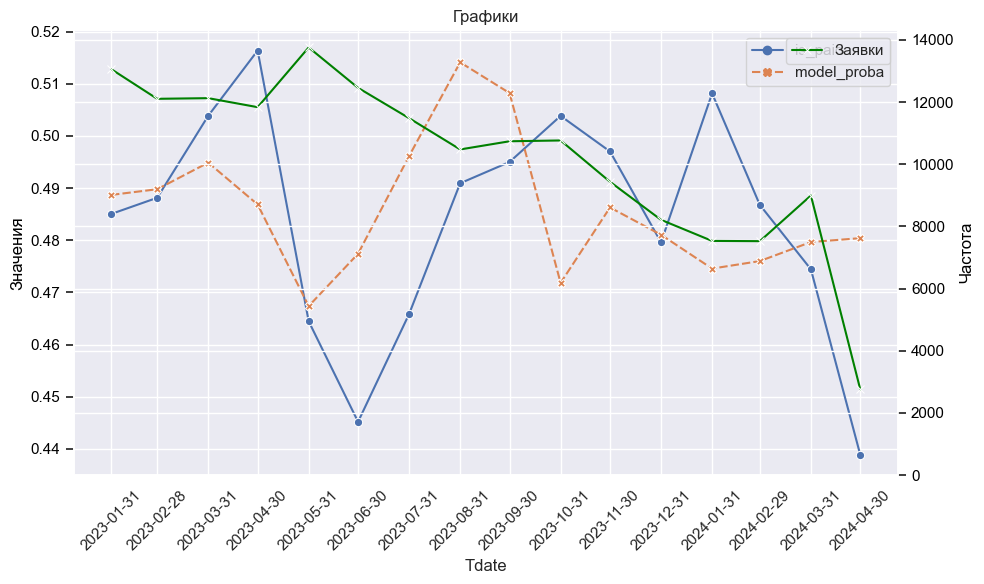

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Пример данных
# big_data_1 должен быть определен заранее

# Создание фигуры и осей
fig, ax1 = plt.subplots(figsize=(10, 6))

# Построение графика для первых двух столбцов
sns.lineplot(data=big_data_1[['is_paid', 'model_proba']], ax=ax1, markers=True)
ax1.set_ylabel('Значения', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Установка меток на оси X
ax1.set_xticks(big_data_1.index)
ax1.set_xticklabels(big_data_1.index.strftime('%Y-%m-%d'), rotation=45)

# Создание второй оси для гистограммы
ax2 = ax1.twinx()  # Создание второй оси y

# Построение зеленой линии с крестиками
sns.lineplot(data=big_data_1['zayavki'], ax=ax2, color='green', markers='o', marker='x', label='Заявки')

# Установка границ для оси Y гистограммы
ax2.set_ylim(0, ax2.get_ylim()[1])  # Установка верхней границы оси Y для гистограммы
ax2.set_ylabel('Частота', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Заголовок графика
plt.title('Графики')

# Показ графика
plt.tight_layout()  # Автоматическая настройка отступов
plt.show()

# Стабильность признаков

In [71]:
data_train[cat] = woe_encoder.transform(data_train[cat])

C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\3662025668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train[cat] = woe_encoder.transform(data_train[cat])


In [72]:
d_gini = pd.DataFrame(index=data_train.drop(['DraftId', 'is_paid', 'type', 'model_proba', 'model_answer'], axis = 1).columns)

# Расчет коэффициента Джини для каждой переменной
for var in data_train.drop(['DraftId', 'is_paid', 'type', 'model_proba', 'model_answer'], axis = 1).columns:
    # Расчет Gini для обучающей выборки
    gini_train = round(1 - (2 * roc_auc_score(data_train['is_paid'], data_train[var].fillna(-99999))), 3)
    d_gini.loc[var, 'Gini_train'] = gini_train*100
    
    # Расчет Gini для тестовой выборки
    gini_test = round(1 - (2 * roc_auc_score(data_test['is_paid'], data_test[var].fillna(-99999))), 3)
    d_gini.loc[var, 'Gini_test'] = gini_test*100
    
    # Расчет Gini для OOT выборки
    

# Вывод результата

In [73]:
d_gini#[d_gini.index.isin(list(set(list(d_gini.index)) & set(list((features.columns)))) )]

,Gini_train,Gini_test
Count_12_len_num,19.2,20.0
s_Amount_60,-17.6,-17.6
over_mfo,18.0,16.2
all_act_cred_2,16.5,14.6
sum_overdue,16.8,15.1
Amount,-17.9,-17.7
Count_456_len_num,16.5,13.4
miAmount_45,-15.5,-15.1
day_overdue,13.6,11.8
s_Amount_30,-12.7,-12.5


In [74]:
dd_gini = d_gini.copy()
a = []
for number in range(0, len(d_gini)):  # b + 1, чтобы включить b
    a.append(number)
dd_gini['index'] = a
dd_gini.set_index('index', inplace = True)
dd_gini['take'] = 1
for i in range(len(d_gini)):    
    if ( ((dd_gini.loc[i,'Gini_train'] < 0) & (dd_gini.loc[i,'Gini_test'] > 0) ) | ( (dd_gini.loc[i,'Gini_train'] > 0) & (dd_gini.loc[i,'Gini_test'] < 0) )) | (abs(dd_gini.loc[i,'Gini_train']) < 3):
        dd_gini.loc[i,'take'] = 0
dd_gini
a = dd_gini['take'].tolist()
d_gini['mask'] = a
d_gini[d_gini['mask'] == 0]

,Gini_train,Gini_test,mask
Tdate,-0.4,2.9,0


# ответы модели в excel

In [75]:
short_answer = data_answer[['DraftId', 'Tdate', 'type', 'model_proba', 'model_answer']]
#short_answer.rename(columns = {'DraftId': 'DraftId'}, inplace = True)

In [76]:
dd = data_answer[['DraftId', 'model_proba', 'is_paid', 'type']]
dd.reset_index(inplace = True, drop = True)
for i in range(len(dd)): 
    if (dd.loc[i, 'model_proba'] < 0.1) & (dd.loc[i, 'model_proba']  >= 0):
        dd.loc[i, 'model_proba'] = '[0;10)'
        continue
    if (dd.loc[i, 'model_proba'] < 0.2) & (dd.loc[i, 'model_proba']  >= 0.1):
        dd.loc[i, 'model_proba'] = '[10;20)'
        continue
    if (dd.loc[i, 'model_proba'] < 0.3) & (dd.loc[i, 'model_proba']  >= 0.2):
        dd.loc[i, 'model_proba'] = '[20;30)'    
        continue
    if (dd.loc[i, 'model_proba'] < 0.4) & (dd.loc[i, 'model_proba']  >= 0.3):
        dd.loc[i, 'model_proba'] = '[30;40)'
        continue
    if (dd.loc[i, 'model_proba'] < 0.5) & (dd.loc[i, 'model_proba']  >= 0.4):
        dd.loc[i, 'model_proba'] = '[40;50)'  
        continue
    if (dd.loc[i, 'model_proba'] < 0.6) & (dd.loc[i, 'model_proba']  >= 0.5):
        dd.loc[i, 'model_proba'] = '[50;60)' 
        continue
    if (dd.loc[i, 'model_proba'] < 0.7) & (dd.loc[i, 'model_proba']  >= 0.6):
        dd.loc[i, 'model_proba'] = '[60;70)'
        continue
    if (dd.loc[i, 'model_proba'] < 0.8) & (dd.loc[i, 'model_proba']  >= 0.7):
        dd.loc[i, 'model_proba'] = '[70;80)'
        continue
    if (dd.loc[i, 'model_proba'] < 0.9) & (dd.loc[i, 'model_proba']  >= 0.8):
        dd.loc[i, 'model_proba'] = '[80;90)'
        continue
    if (dd.loc[i, 'model_proba'] <= 1) & (dd.loc[i, 'model_proba']  >= 0.9):
        dd.loc[i, 'model_proba'] = '[90;100]'        
        continue

wc = pd.read_excel('Desktop\Модели и их датафреймы\Обуч до февраля новая\Working Capital (1).xlsx')
wc.drop(['Model_answer', 'Вероятность', 'Бакет', 'target', 'Type', 'is_paid'], axis = 1, inplace = True)
wc = wc.merge(dd, how = 'inner', on = 'DraftId')
wc = wc[wc['type'] == 'test']

C:\Users\grishin\AppData\Local\Temp\ipykernel_12756\2183569458.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[30;40)' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  dd.loc[i, 'model_proba'] = '[30;40)'


In [92]:
wc

,DraftId,dpd0,dpd15,dpd30,dpd60,dpd90,LoanAmount,model_proba,is_paid,type
32,95A899E9-7311-4E9C-8816-5E4DFECF03B0,0.0,2448.0,3888.0,3888.0,8640.0,9000,[50;60),0.0,test
65,B74C8759-D592-440A-ADEF-BEFD2469A29C,16408.8,16408.8,16408.8,16408.8,16408.8,15900,[80;90),1.0,test
70,4C9042BA-68EE-427A-B338-FDE04612D652,16449.6,16449.6,16449.6,16449.6,16449.6,14900,[50;60),1.0,test
75,0A148FBC-31C0-4A01-BACC-3AC1CDF7D289,0.0,0.0,0.0,0.0,0.0,12900,[40;50),0.0,test
83,074C9111-B241-412D-89DC-CB7B77F52256,0.0,0.0,0.0,0.0,0.0,14900,[40;50),0.0,test
...,...,...,...,...,...,...,...,...,...,...
163240,F9200331-3EEF-4721-A519-40AEF0FB0D6F,0.0,0.0,8610.0,8610.0,8610.0,30000,[30;40),0.0,test
163265,732ED158-2587-4C77-A150-D09CAB2541C7,15704.0,15704.0,15704.0,15704.0,15704.0,13000,[70;80),1.0,test
163277,7A292402-D5C5-4585-9C8B-9DFE10BCF6C6,1832.8,1832.8,1832.8,4037.8,4037.8,7900,[50;60),0.0,test
163279,A3B848D7-4549-4A92-9933-821DF0A60093,0.0,0.0,0.0,0.0,0.0,11000,[50;60),0.0,test


In [93]:
vtoroi_zaim = pd.read_excel('Desktop/Достижение 5го займа (1).xlsx')


In [94]:
wc = wc.merge(vtoroi_zaim, on = 'DraftId', how = 'inner')

In [95]:
wc

,DraftId,dpd0,dpd15,dpd30,dpd60,dpd90,LoanAmount,model_proba,is_paid,type,cur_loan_num,took_5th_loan
0,95A899E9-7311-4E9C-8816-5E4DFECF03B0,0.0,2448.0,3888.0,3888.0,8640.0,9000,[50;60),0.0,test,3,0
1,B74C8759-D592-440A-ADEF-BEFD2469A29C,16408.8,16408.8,16408.8,16408.8,16408.8,15900,[80;90),1.0,test,3,1
2,4C9042BA-68EE-427A-B338-FDE04612D652,16449.6,16449.6,16449.6,16449.6,16449.6,14900,[50;60),1.0,test,2,0
3,0A148FBC-31C0-4A01-BACC-3AC1CDF7D289,0.0,0.0,0.0,0.0,0.0,12900,[40;50),0.0,test,2,0
4,074C9111-B241-412D-89DC-CB7B77F52256,0.0,0.0,0.0,0.0,0.0,14900,[40;50),0.0,test,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19273,F9200331-3EEF-4721-A519-40AEF0FB0D6F,0.0,0.0,8610.0,8610.0,8610.0,30000,[30;40),0.0,test,5,1
19274,732ED158-2587-4C77-A150-D09CAB2541C7,15704.0,15704.0,15704.0,15704.0,15704.0,13000,[70;80),1.0,test,2,0
19275,7A292402-D5C5-4585-9C8B-9DFE10BCF6C6,1832.8,1832.8,1832.8,4037.8,4037.8,7900,[50;60),0.0,test,3,0
19276,A3B848D7-4549-4A92-9933-821DF0A60093,0.0,0.0,0.0,0.0,0.0,11000,[50;60),0.0,test,3,0


In [96]:
wc.to_csv('wc_15.11_droped_bad_features + seconszaim.csv', index = False)

# Прогон отказников

In [ ]:
otkazniki = pd.read_excel('Desktop/Данные по отказным заявкам.xlsx')
сat = ['Amount',
 'd_cnt_R',
 'all_act_cred',
 'N_90_365',
 'delay30_1',
 'prev_loans_cnt',
 'delay60_1',
 'd_cnt_12030',
 'delay_more_2',
 'delay90_3',
 'delay5_22',
 'prev_drafts_cnt',
 'dog_bad',
 'Gender']



In [78]:
otkazniki.fillna(0, inplace = True)
otkazniki[cat] = woe_encoder.transform(otkazniki[cat])

C:\ProgramData\Anaconda3\lib\site-packages\feature_engine\encoding\base_encoder.py:255: UserWarning: During the encoding, NaN values were introduced in the feature(s) Amount, all_act_cred, N_90_365, delay30_1, delay60_1, delay_more_2, delay5_22, prev_drafts_cnt, Gender.
  warnings.warn(


In [79]:
otkazniki = otkazniki[features.drop('Tdate', axis = 1).columns]

In [80]:
otkazniki.head()

,DraftId,Count_12_len_num,s_Amount_60,over_mfo,all_act_cred_2,sum_overdue,Amount,Count_456_len_num,miAmount_45,day_overdue,s_Amount_30,miAmount_90,d_cnt_R,Dola_RD_1,s_Amount,all_act_cred,cred_date_last_1,delay30_1,all_cred_rep_13,delay5_2,prolong_1,prolong,Cred_Deb_2,last_payment,delay60_1,all_act_cred_s,d_cnt_12030,cred_date_last_2,cred_sum_1,avg_12_month,cred_date_last,partner_type_1,all_rep_cred_1,partner_type_3,ti_year,ti_quarter
0,AE4E7572-F5DA-440A-9314-A16F6BA598B3,0.1087,0,46485.40,0.205882,46824.95,0.550141,0.0761,0.0000,340,0,0.0000,-0.325488,0.000000,16800,0.136250,56.0,-0.157988,0.118181,9,1,16,5.4560,40,-0.265797,-543586.81,-0.024484,56.0,247208.0,16614.58,377.0,34000000.0,-0.069474,2.290000e+08,67.0,31.0
1,8B2DF5C2-B07A-4866-BD27-4C9C2DB264A8,0.1456,0,70861.49,0.333333,70861.49,-0.229361,0.0889,0.0000,131,0,0.0000,-0.325488,0.000000,16000,-0.115031,27.0,-0.497859,0.241689,29,7,13,2.3467,68,-0.308115,-563752.00,-0.024484,9.0,643644.0,66883.30,9.0,57000000.0,-0.168068,2.080000e+08,91.0,24.0
2,44E466F9-9A38-4FC3-9390-77649EF796F2,0.1049,8900,98065.53,0.266666,98065.53,-0.229361,0.1042,0.9889,568,0,0.9889,0.104642,0.490263,15800,-0.193812,20.0,-0.160679,0.455956,5,10,15,2.6020,14,-0.597719,-244818.00,-0.024484,5.0,1500354.0,155753.80,5.0,105000000.0,0.125724,2.027000e+09,132.0,62.0
3,9ED45957-8694-4F88-B5EE-4F9967FFC04D,0.0565,0,23550.00,0.157894,29050.00,-0.169673,0.0847,0.0000,1760,0,0.0000,-0.325488,0.000000,13800,0.439710,12.0,-0.038764,0.204613,0,0,22,0.3376,33,-0.204861,-79400.00,-0.099939,12.0,114400.0,8289.47,16.0,19000000.0,0.029788,2.460002e+08,63.0,9.0
4,5316EA4F-2454-40A6-8FF7-3D68B19BBA5E,0.1455,0,73040.18,0.263157,73040.18,-0.229361,0.1218,0.0000,351,0,0.0000,-0.325488,0.000000,15900,-0.012365,78.0,-0.260863,0.313754,12,18,22,7.4651,80,-0.265400,-173563.00,-0.099939,12.0,380263.0,33517.54,12.0,38000000.0,-0.070703,4.460000e+08,71.0,13.0


In [81]:
otkazniki[features.drop('Tdate', axis = 1).columns]

,DraftId,Count_12_len_num,s_Amount_60,over_mfo,all_act_cred_2,sum_overdue,Amount,Count_456_len_num,miAmount_45,day_overdue,s_Amount_30,miAmount_90,d_cnt_R,Dola_RD_1,s_Amount,all_act_cred,cred_date_last_1,delay30_1,all_cred_rep_13,delay5_2,prolong_1,prolong,Cred_Deb_2,last_payment,delay60_1,all_act_cred_s,d_cnt_12030,cred_date_last_2,cred_sum_1,avg_12_month,cred_date_last,partner_type_1,all_rep_cred_1,partner_type_3,ti_year,ti_quarter
0,AE4E7572-F5DA-440A-9314-A16F6BA598B3,0.1087,0,46485.40,0.205882,46824.95,0.550141,0.0761,0.0000,340,0,0.0000,-0.325488,0.000000,16800,0.136250,56.0,-0.157988,0.118181,9,1,16,5.4560,40,-0.265797,-543586.81,-0.024484,56.0,247208.0,16614.58,377.0,34000000.0,-0.069474,2.290000e+08,67.0,31.0
1,8B2DF5C2-B07A-4866-BD27-4C9C2DB264A8,0.1456,0,70861.49,0.333333,70861.49,-0.229361,0.0889,0.0000,131,0,0.0000,-0.325488,0.000000,16000,-0.115031,27.0,-0.497859,0.241689,29,7,13,2.3467,68,-0.308115,-563752.00,-0.024484,9.0,643644.0,66883.30,9.0,57000000.0,-0.168068,2.080000e+08,91.0,24.0
2,44E466F9-9A38-4FC3-9390-77649EF796F2,0.1049,8900,98065.53,0.266666,98065.53,-0.229361,0.1042,0.9889,568,0,0.9889,0.104642,0.490263,15800,-0.193812,20.0,-0.160679,0.455956,5,10,15,2.6020,14,-0.597719,-244818.00,-0.024484,5.0,1500354.0,155753.80,5.0,105000000.0,0.125724,2.027000e+09,132.0,62.0
3,9ED45957-8694-4F88-B5EE-4F9967FFC04D,0.0565,0,23550.00,0.157894,29050.00,-0.169673,0.0847,0.0000,1760,0,0.0000,-0.325488,0.000000,13800,0.439710,12.0,-0.038764,0.204613,0,0,22,0.3376,33,-0.204861,-79400.00,-0.099939,12.0,114400.0,8289.47,16.0,19000000.0,0.029788,2.460002e+08,63.0,9.0
4,5316EA4F-2454-40A6-8FF7-3D68B19BBA5E,0.1455,0,73040.18,0.263157,73040.18,-0.229361,0.1218,0.0000,351,0,0.0000,-0.325488,0.000000,15900,-0.012365,78.0,-0.260863,0.313754,12,18,22,7.4651,80,-0.265400,-173563.00,-0.099939,12.0,380263.0,33517.54,12.0,38000000.0,-0.070703,4.460000e+08,71.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32027,880DA150-4E40-4960-AB3C-C44483E377B7,0.1200,9900,42091.84,0.245901,42091.84,0.011621,0.0697,0.0000,255,0,0.9000,0.104642,0.000000,26700,-0.085296,8.0,-0.163580,0.466673,8,25,25,3.3670,8,-0.273096,-50304.00,-0.024484,6.0,642562.0,52559.72,6.0,160000000.0,0.093083,2.600000e+08,155.0,62.0
32028,6D744F1C-5930-457A-9951-0CA72B60C1C3,0.1186,0,22000.00,1.000000,36367.38,0.954384,0.2458,0.0000,1792,0,0.0000,-0.325488,0.000000,9000,0.136250,343.0,0.189987,0.530376,2,0,4,4.2000,345,0.107674,7382.00,-0.099939,62.0,26000.0,3548.20,62.0,4000000.0,-0.469624,2.150001e+08,6.0,44.0
32029,986E0298-4572-49F3-861D-10CDB42AD264,0.1294,0,36450.00,0.258823,47513.91,0.011621,0.0420,0.0000,261,0,1.0818,-0.325488,0.000000,17900,-0.170401,14.0,-0.185543,0.324093,6,2,2,2.1806,26,-0.308115,-306139.90,0.255480,3.0,895180.1,57863.26,3.0,580000000.0,0.000000,5.800000e+08,122.0,56.0
32030,7C021D21-008E-4A09-94D2-D5E51C1885C6,0.1485,0,12870.00,0.358024,12870.00,0.087222,0.0570,0.0000,3,0,0.0000,-0.325488,0.000000,17700,-0.291033,13.0,0.189987,0.361984,6,78,84,1.5832,501,0.107674,-375691.90,-0.099939,2.0,1008119.1,64430.17,2.0,576000000.0,-0.105895,6.080000e+08,56.0,34.0


In [85]:
proba = model_35.predict_proba(otkazniki[features.drop('Tdate', axis = 1).columns].drop(['DraftId'], axis = 1))[:,1]
predict = model_35.predict(otkazniki[features.drop('Tdate', axis = 1).columns].drop('DraftId', axis = 1))

In [86]:
otkazniki['proba'] = proba
otkazniki['model_answer'] = predict

In [89]:
otkazniki[otkazniki['model_answer'] == 1]

,DraftId,Count_12_len_num,s_Amount_60,over_mfo,all_act_cred_2,sum_overdue,Amount,Count_456_len_num,miAmount_45,day_overdue,s_Amount_30,miAmount_90,d_cnt_R,Dola_RD_1,s_Amount,all_act_cred,cred_date_last_1,delay30_1,all_cred_rep_13,delay5_2,prolong_1,prolong,Cred_Deb_2,last_payment,delay60_1,all_act_cred_s,d_cnt_12030,cred_date_last_2,cred_sum_1,avg_12_month,cred_date_last,partner_type_1,all_rep_cred_1,partner_type_3,ti_year,ti_quarter,proba,model_answer
6,5BF200ED-F31E-4775-B667-EFB87E328250,0.1010,8000,0.00,0.314814,0.00,-0.229361,0.0997,0.8889,0,8000,0.8889,0.308572,0.583529,14000,-0.181946,22.0,0.189987,0.606462,2,1,3,1.8889,5,0.107674,257142.00,-0.024484,5.0,1052664.00,88614.09,5.0,252000000.0,0.057947,5.520000e+08,72.0,57.0,0.567095,1
7,86150A17-9031-4340-B7C9-E19BEA813E3A,0.0645,24800,0.00,0.245901,1913.01,-0.278199,0.0645,1.1835,2833,12900,1.0000,0.308572,1.000000,46600,-0.044530,38.0,0.189987,0.303055,0,0,0,5.1231,0,0.107674,-267450.00,0.379460,4.0,679000.00,45013.18,4.0,61000000.0,0.000000,2.610000e+08,45.0,31.0,0.675853,1
12,D09D412E-73BD-45A3-82E2-92761401C2E3,0.0669,0,41790.00,0.196581,41790.00,0.669955,0.0742,0.0000,280,0,0.0000,-0.325488,0.000000,18000,-0.229274,46.0,-0.157988,0.338526,16,9,9,8.4650,89,-0.204861,-279208.96,-0.024484,2.0,765245.10,73698.90,2.0,315000000.0,0.092233,5.150000e+08,169.0,26.0,0.547783,1
17,11979185-746D-468A-A752-1710FB8E1BC4,0.0796,8900,0.00,0.173913,0.00,-0.229361,0.0626,0.0000,0,0,0.9889,0.104642,0.414310,16800,-0.093333,18.0,-0.191298,0.420529,2,2,3,2.5778,39,-0.265797,-161100.90,-0.024484,3.0,978585.00,64935.67,3.0,168000000.0,0.020726,3.680000e+08,104.0,44.0,0.545121,1
20,0623C0C1-4A5D-4EDD-B09A-50EED1A1A92A,0.0308,15900,0.00,0.090909,129046.24,0.418921,0.0308,1.0000,1518,15900,0.3774,0.308572,1.000000,21900,0.627788,9.0,0.189987,0.314954,0,1,2,1.5411,8,0.107674,-193885.00,-0.024484,6.0,523885.00,64168.97,6.0,231000000.0,0.000000,7.310000e+08,37.0,18.0,0.887183,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31993,D987CBDA-36E5-449D-9C73-7B8E1E825CFE,0.1512,0,39378.51,0.282051,39378.51,0.954384,0.0748,0.0000,370,0,0.0000,-0.325488,0.000000,23700,-0.011932,46.0,-0.238982,0.316580,8,21,27,33.9210,25,-0.314557,-139014.00,-0.099939,4.0,314174.00,24512.59,4.0,138000000.0,-0.030262,2.490000e+08,123.0,24.0,0.564038,1
32011,22B70C26-01A2-45C8-BE92-A3AF16ED2DA6,0.0914,0,0.00,0.190476,0.00,0.087222,0.0545,0.0000,0,0,0.0000,-0.325488,0.000000,17900,0.136250,36.0,-0.038764,0.251926,16,37,40,6.0365,90,-0.308115,-776341.40,-0.099939,1.0,1000976.40,118244.39,1.0,240000000.0,-0.141889,1.274000e+09,63.0,21.0,0.573024,1
32013,796C8BFB-920B-4401-802C-1578B9765DAF,0.1078,9900,10460.00,0.217391,23166.28,0.071678,0.0663,1.2375,3446,0,1.2375,0.308572,0.000000,38600,-0.012365,32.0,-0.367772,0.219705,3,14,14,6.7756,0,0.107674,-203231.00,0.255480,8.0,338531.00,29226.24,8.0,46000000.0,-0.015576,2.500002e+08,35.0,46.0,0.514745,1
32019,DF46A28D-0401-42F9-98FA-724FF55606A2,0.1169,11000,0.00,0.259259,88998.97,0.071678,0.0771,0.0000,74,0,1.3750,0.104642,0.535725,17900,-0.064137,49.0,-0.080514,0.397752,1,12,29,3.1210,22,-0.204861,-327828.55,-0.024484,19.0,203108.55,27637.42,19.0,522000000.0,0.064729,2.425000e+09,67.0,17.0,0.541469,1


In [90]:
otkazniki.shape

(32032, 38)

In [91]:
otkazniki.to_csv('model_on_deny.csv')